- 100k canddatos
- tirar nans e notas < 1
- por matéria: colocar a nota como inteiro e agrupar por nota. pegar 5 pessoas q tiveram a mesma nota (aleatório). Pegar + a nota máxima como float. O resto da amostra pega aleatório até dar 100k.


### Imports e Upload do dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from scipy.optimize import basinhopping
import xgboost as xgb
from sklearn.model_selection import cross_val_predict, KFold
import matplotlib.colors as colors
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

In [2]:
# # df_acertos = pd.read_parquet(r'C:\Users\Usuário\Desktop\PCD\tabelas_parquet\acertos_subamostra.parquet')
# # df_enems = pd.read_parquet(r'C:\Users\Usuário\Desktop\PCD\tabelas_parquet\enems_subamostra.parquet')
# # df_gabaritos = pd.read_parquet(r'C:\Users\Usuário\Desktop\PCD\tabelas_parquet\gabaritos.parquet')

df_acertos = pd.read_parquet('acertos_subamostra.parquet')
df_enems = pd.read_parquet('enems_subamostra.parquet')
df_gabaritos = pd.read_parquet('gabaritos.parquet')

df_enems = df_enems.merge(df_gabaritos[['CO_PROVA', 'COR']], left_on='CO_PROVA_MT', right_on='CO_PROVA')
df = df_acertos.merge(df_enems[['NU_INSCRICAO', 'COR']], left_on='NU_INSCRICAO', right_on='NU_INSCRICAO')

df = df[(df['NU_ANO'] == 2023) & ~df['COR'].isna()]
df


,NU_INSCRICAO,NU_ANO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,TP_LINGUA,NU_NOTA_LC,NU_NOTA_CH,NU_NOTA_CN,...,Q177,Q178,Q179,Q180,Q181,Q182,Q183,Q184,Q185,COR
151170,210058036237,2023,1,1,1,1,0,447.5,511.4,499.8,...,1,0,1,0,0,0,0,1,1,Azul
151171,210058036273,2023,1,1,1,1,0,591.8,648.6,647.7,...,0,0,0,0,1,1,1,1,1,Azul
151172,210058036463,2023,1,1,1,1,0,588.4,658.2,640.3,...,0,1,1,0,1,1,1,1,1,Amarelo
151173,210058036521,2023,1,1,1,1,1,685.4,671.1,657.6,...,0,1,1,0,0,1,0,0,0,Azul
151174,210058036625,2023,1,1,1,1,1,501.9,457.4,398.0,...,0,0,1,0,0,1,1,1,0,Azul
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192066,210062061309,2023,1,1,1,1,0,481.8,429.5,493.4,...,0,0,1,0,1,1,1,1,1,Rosa
192067,210062061468,2023,1,1,1,1,0,545.3,518.8,470.1,...,0,0,1,0,0,0,0,0,1,Rosa
192068,210062061543,2023,1,1,1,1,0,547.0,464.0,530.2,...,1,0,0,0,1,0,1,0,1,Azul
192069,210062061582,2023,1,1,1,1,0,541.9,545.1,560.9,...,0,1,0,0,0,0,0,1,0,Branco


In [ ]:
df.columns

### Primeiro treinamento

* MATEMÁTICA

In [4]:
df = df[df['NU_NOTA_MT']>1]

In [5]:
colunas_desejadas = ['NU_NOTA_MT'] + [f'Q{i}' for i in range(141, 186) if i != 169]  # ANULADA
df = df[colunas_desejadas].dropna()

df = df.astype(float)

treino_val_test = [80, 10, 10]
normalized_split = [x / sum(treino_val_test) for x in treino_val_test]

train_size = int(len(df) * normalized_split[0])
val_size = int(len(df) * normalized_split[1])
test_size = len(df) - train_size - val_size

# Dividindo o DataFrame --  DADOS JÁ ALEATORIZADOS
df_train = df[:train_size]
df_val = df[train_size:train_size+val_size]
df_test = df[train_size+val_size:]

# Calculando média e std no treino
mean_train = df_train['NU_NOTA_MT'].mean()
std_train = df_train['NU_NOTA_MT'].std()

# Normalizando usando valores do treino
df_train['NU_NOTA_MT'] = (df_train['NU_NOTA_MT'] - mean_train) / std_train
df_val['NU_NOTA_MT'] = (df_val['NU_NOTA_MT'] - mean_train) / std_train
df_test['NU_NOTA_MT'] = (df_test['NU_NOTA_MT'] - mean_train) / std_train

df_train

,NU_NOTA_MT,Q141,Q142,Q143,Q144,Q145,Q146,Q147,Q148,Q149,...,Q176,Q177,Q178,Q179,Q180,Q181,Q182,Q183,Q184,Q185
151170,-0.396550,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
151171,1.211509,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
151172,1.612331,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
151173,0.396346,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
151174,-0.688418,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183865,-0.409275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
183866,-1.012893,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
183867,0.391574,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
183868,-1.223643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


pegando 5 pessoas de cada bin deram 2290 instancias.
pegando 15 pessoas de cada bin deram 6306 instancias.

NameError: name 'df_amostrado' is not defined

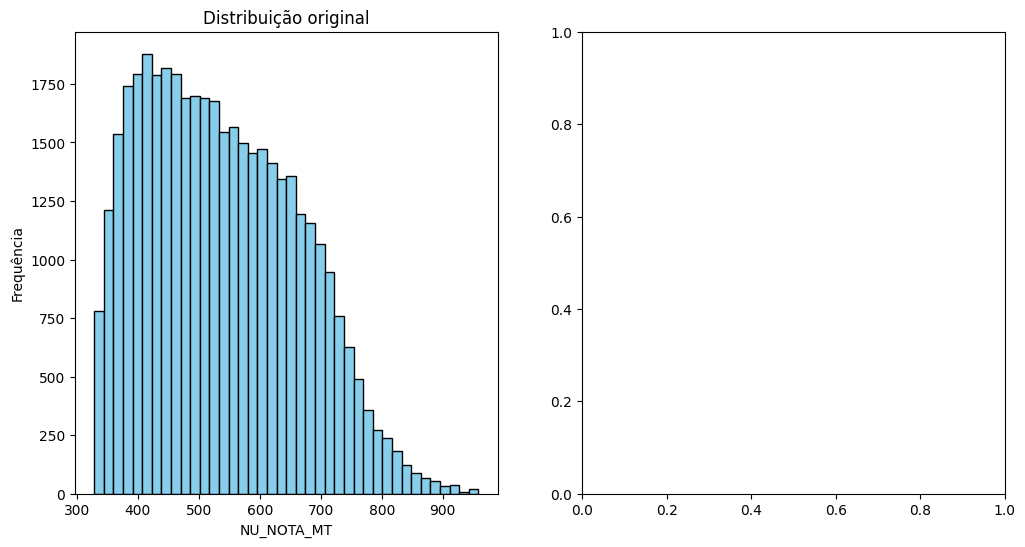

In [6]:
# 8. Gráfico de comparação
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(df['NU_NOTA_MT'], bins=40, color='skyblue', edgecolor='black')
plt.title('Distribuição original')
plt.xlabel('NU_NOTA_MT')
plt.ylabel('Frequência')

plt.subplot(1, 2, 2)
plt.hist(df_amostrado['NU_NOTA_MT'], bins=40, color='red', edgecolor='black')
plt.title('Distribuição após amostragem (meio) estratificada')
plt.xlabel('NU_NOTA_MT')
plt.ylabel('Frequência')

plt.tight_layout()
plt.show()

In [ ]:
# Calcular o número de acertos para cada candidato no conjunto de treino
acertos_train = df_train.drop('NU_NOTA_MT', axis=1).sum(axis=1).astype(int)

# Adicionar coluna 'acertos' no df_train para facilitar o agrupamento
df_train_grouped = df_train.copy()
df_train_grouped['acertos'] = acertos_train

# Agrupar por número de acertos e calcular média, std e contagem da nota TRI
media = df_train_grouped.groupby('acertos')['NU_NOTA_MT'].agg(['mean', 'std', 'count']).reset_index()

# Criar um dicionário que mapeia número de acertos para a média da nota TRI
mapa_media = dict(zip(media['acertos'], media['mean']))

acertos_val = df_val.drop('NU_NOTA_MT', axis=1).sum(axis=1).astype(int)
notas_val = df_val['NU_NOTA_MT']

notas_estimadas_val = acertos_val.map(mapa_media)
notas_estimadas_val = notas_estimadas_val.fillna(df_train['NU_NOTA_MT'].mean())

r2_val = r2_score(notas_val, notas_estimadas_val)
rmse_val = np.sqrt(mean_squared_error(notas_val, notas_estimadas_val))

print(f"R² validação: {r2_val:.4f}")
print(f"RMSE validação: {rmse_val:.4f}")

# --- Gráfico baseado no conjunto de treino ---
plt.figure(figsize=(7, 4))

plt.boxplot([df_train_grouped[df_train_grouped['acertos'] == acerto]['NU_NOTA_MT'] for acerto in media['acertos']],
            positions=range(len(media['acertos'])), widths=0.6, showfliers=False)

plt.xticks(range(0, len(media['acertos']), 5), labels=[str(acerto) for acerto in media['acertos'][::5]], fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('Número de Acertos', fontsize=8)
plt.ylabel('Nota TRI', fontsize=8)
plt.title('Predição pela Média de Nota agrupada por Acertos', fontsize=10)

# Colocar as métricas do conjunto de validação no gráfico do treino
plt.text(0.02, 0.95, f'R² = {r2_val:.2f}    RMSE = {rmse_val:.2f}',
         transform=plt.gca().transAxes, ha='left', va='top', fontsize=9,
         bbox=dict(facecolor='white', alpha=0.7))

plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
def P(TRI, a, b, c): #função logística
    return c + (1 - c) / (1 + np.exp(-a*(TRI - b)))

In [ ]:
def custo_ridge(params, x, y, prioris, alpha=0.05):
    a, b, c = params
    y_pred = P(x, a, b, c)
    erro = np.sum((y - y_pred) ** 2)
    penalizacao = alpha * ((a-prioris[0])**2 + (b-prioris[1])**2 + (c-prioris[2])**2)
    return erro + penalizacao

In [ ]:
def otimizar_ridge(df_train, questoes, limites, custo_ridge, prioris, alpha=0.25):
    x = df_train['NU_NOTA_MT'].values
    parametros_ridge = pd.DataFrame(index=questoes, columns=['a', 'b', 'c'])

    for q in questoes:
        try:
            y = df_train[q].values

            # Definição da função com os argumentos fixos
            func = lambda params: custo_ridge(params, x, y, prioris, alpha)

            # Chute inicial razoável
            x0 = prioris

            # Constraint bounds para basinhopping
            minimizer_kwargs = {
                "method": "L-BFGS-B",
                "bounds": limites
            }

            # Executa o basinhopping
            resultado = basinhopping(func, x0, minimizer_kwargs=minimizer_kwargs, niter=25, disp=False)

            if resultado.lowest_optimization_result.success:
                parametros_ridge.loc[q] = resultado.x
            else:
                parametros_ridge.loc[q] = [np.nan, np.nan, np.nan]
                print(f"Erro ao ajustar a questão {q}: otimização não convergiu.")

        except Exception as e:
            print(f"Erro ao ajustar a questão {q}: {e}")
            parametros_ridge.loc[q] = [np.nan, np.nan, np.nan]

    return parametros_ridge


In [ ]:
questoes = [f'Q{i}' for i in range(141, 186) if i != 169]
limites = [(0.1, 5),(-4,4), (0,1)]
prioris = [2, 0, 0.2]
parametros = otimizar_ridge(df_train, questoes, limites, custo_ridge, prioris, alpha=0.25)
parametros

In [ ]:
parametros.to_csv('parametros_abc_MT.csv')

In [ ]:
a_vec = parametros['a'].astype(float)
b_vec = parametros['b'].astype(float)
c_vec = parametros['c'].astype(float)
print(P(2, a_vec, b_vec ,c_vec).mean())

In [ ]:
q = 146
i = q - 141
if q > 166:
    i -=1
theta_range = np.linspace(-2, 4, 100)
P_values = P(theta_range, a_vec[i], b_vec[i], c_vec[i])

plt.ylim(-0.1,1.1)
plt.plot(theta_range, P_values)
plt.xlabel('Theta (habilidade)')
plt.ylabel('P(Theta)')
plt.title('Comportamento da função logística para questão '+str(q))
plt.grid(True)
plt.show()


In [ ]:
limites_theta = (df_train['NU_NOTA_MT'].min(), df_train['NU_NOTA_MT'].max())

# Função de erro para um candidato (vetores de a, b, c)
def erro_para_candidato(theta, respostas, a_vec, b_vec, c_vec):
    P_pred = P(theta, a_vec, b_vec, c_vec)
    return np.sum((respostas - P_pred) ** 2)

# Aproximação numérica da primeira derivada
def derivada_primeira(func, theta, respostas, a_vec, b_vec, c_vec, epsilon=1e-4):
    return (func(theta + epsilon, respostas, a_vec, b_vec, c_vec) - func(theta - epsilon, respostas, a_vec, b_vec, c_vec)) / (2 * epsilon)

# Aproximação numérica da segunda derivada
def derivada_segunda(func, theta, respostas, a_vec, b_vec, c_vec, epsilon=1e-4):
    return (derivada_primeira(func, theta + epsilon, respostas, a_vec, b_vec, c_vec, epsilon) -
            derivada_primeira(func, theta - epsilon, respostas, a_vec, b_vec, c_vec, epsilon)) / (2 * epsilon)

In [ ]:
def calcular_nota_estimativa(dados, questoes, a_vec, b_vec, c_vec, th=0.02):
    notas_TRI = []
    derivadas_segunda = []
    ranges_minimos = []
    dados = dados.copy()

    for _, linha in dados.iterrows():
        respostas = linha[questoes].values.astype(float)
        minimos_encontrados = []

        # Para capturar f(x) de cada mínimo
        valores_f = []

        def registrar_minimos(x, f, accept):
            if accept:
                minimos_encontrados.append(x[0])
                valores_f.append(f)

        resultado = basinhopping(
            erro_para_candidato,
            x0=[0],
            minimizer_kwargs={
                "method": "L-BFGS-B",
                "bounds": [limites_theta],
                "args": (respostas, a_vec, b_vec, c_vec),
                "options": {"ftol": 1e-2}
            },
            niter=25,
            disp=False,
            callback=registrar_minimos
        )

        theta = resultado.x[0]
        f_melhor = resultado.fun

        f_pior = max(erro_para_candidato(-10, respostas, a_vec, b_vec, c_vec), erro_para_candidato(10, respostas, a_vec, b_vec, c_vec))

        # Calcula segunda derivada no mínimo global
        segunda_derivada = derivada_segunda(erro_para_candidato, theta, respostas, a_vec, b_vec, c_vec, 5e-2)

        # Filtra mínimos locais com erro suficientemente próximo do melhor
        minimos_filtrados = [x for x, f in zip(minimos_encontrados, valores_f) if f <= f_melhor + (f_pior - f_melhor) * th]
        range_valores = [min(minimos_filtrados), max(minimos_filtrados)]

        # Armazena os resultados
        notas_TRI.append(theta)
        derivadas_segunda.append(segunda_derivada)
        ranges_minimos.append(range_valores)

    dados['NOTA_TRI_ESTIMADA'] = notas_TRI
    dados['DERIVADA_SEGUNDA'] = derivadas_segunda
    dados['ALCANCE_MINIMOS'] = ranges_minimos

    return dados


df_val = calcular_nota_estimativa(df_val, questoes, a_vec, b_vec, c_vec, 0.02)
df_val

In [ ]:
candidatos = df_val.iloc[[2, 3, 6]]
erro_values_all = []

# Calcular os valores do erro para cada candidato no intervalo de -3 a 3
theta_values = np.linspace(-5, 5, 400)

for _, linha in candidatos.iterrows():
    respostas = linha[questoes].values.astype(float)
    erro_values = [erro_para_candidato(theta, respostas, a_vec, b_vec, c_vec) for theta in theta_values]
    erro_values_all.append(erro_values)

# Plotando o erro para todos os candidatos
plt.figure(figsize=(6, 3))

# Adiciona uma linha para cada candidato
for i, erro_values in enumerate(erro_values_all):
    plt.plot(theta_values, erro_values, label=f'Candidato {i+1}')

plt.title('Erro para alguns candidatos em Função de θ', fontsize=10)
plt.xlabel('θ')
plt.ylabel('Erro')
plt.legend()
plt.show()

In [ ]:
y_true, y_pred = df_val['NU_NOTA_MT'].values, df_val['NOTA_TRI_ESTIMADA'].values

r2 = r2_score(y_true, y_pred)

# Criando os subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Relação entre NU_NOTA_MT e NOTA_TRI_ESTIMADA
axes[0].scatter(df_val['NU_NOTA_MT'], df_val['NOTA_TRI_ESTIMADA'], s=3, color='blue', label='Dados')
axes[0].set_title(f'Nota Estimada vs Real\nR² = {r2:.4f}', fontsize=14)
axes[0].set_xlabel('NU_NOTA_MT')
axes[0].set_ylabel('NOTA_TRI_ESTIMADA')
axes[0].legend()

# Gráfico 2: Resíduo (diferença entre as duas colunas)
residuals = df_val['NU_NOTA_MT'] - df_val['NOTA_TRI_ESTIMADA']
axes[1].scatter(df_val['NU_NOTA_MT'], residuals, s=3, color='red', label='Resíduo')
axes[1].set_title('Resíduos', fontsize=14)
axes[1].set_xlabel('NU_NOTA_MT')
axes[1].set_ylabel('Resíduo')
axes[1].axhline(0, color='black', linestyle='--')  # Linha horizontal em zero
axes[1].legend()

# Exibindo os gráficos
plt.tight_layout()
plt.show()

In [ ]:
def bootstrap_r2(y_true, y_pred, n_resamples=1000, ci=0.95, random_state=42):
    rng = np.random.default_rng(random_state)
    n = len(y_true)
    r2_scores = []

    for _ in range(n_resamples):
        indices = rng.integers(0, n, n)  # amostra com reposição
        y_true_sample = y_true[indices]
        y_pred_sample = y_pred[indices]
        r2 = r2_score(y_true_sample, y_pred_sample)
        r2_scores.append(r2)

    r2_scores = np.array(r2_scores)
    lower = np.percentile(r2_scores, (1-ci)/2*100)
    upper = np.percentile(r2_scores, (1 + ci)/2*100)

    return r2_score(y_true, y_pred), (lower, upper)

r2_orig, ci_r2 = bootstrap_r2(y_true, y_pred)

print(f"R² original: {r2_orig:.4f}")
print(f"Intervalo de confiança {int(ci_r2[1]*100)}% para R² pelo bootstrap: [{ci_r2[0]:.4f}, {ci_r2[1]:.4f}]")

In [ ]:
df_res = df_val[['NU_NOTA_MT', 'NOTA_TRI_ESTIMADA','DERIVADA_SEGUNDA','ALCANCE_MINIMOS']]
df_res['QTD_ACERTOS'] = df_val[[f'Q{i}' for i in range(141, 186) if i != 169]].sum(axis=1)
df_res['ALCANCE'] = df_res['ALCANCE_MINIMOS'].apply(lambda x: x[1] - x[0])
df_res

In [ ]:
df_res.columns

In [ ]:
# Criar figura com 2 subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Primeiro subplot: DERIVADA_SEGUNDA
sc1 = axes[0].scatter(df_res['NU_NOTA_MT'], df_res['NOTA_TRI_ESTIMADA'],
                      c=df_res['DERIVADA_SEGUNDA'], cmap='viridis', s=3,
                      vmin=-1, vmax=1)
axes[0].set_title('Nota vs Nota Estimada\n(cor = Segunda Derivada)', fontsize=10)
axes[0].set_xlabel('NU_NOTA_MT', fontsize=8)
axes[0].set_ylabel('NOTA_TRI_ESTIMADA', fontsize=7)
fig.colorbar(sc1, ax=axes[0], label='Segunda Derivada')

# Segundo subplot: ALCANCE com escala log e colormap invertido
sc2 = axes[1].scatter(df_res['NU_NOTA_MT'], df_res['NOTA_TRI_ESTIMADA'],
                      c=df_res['ALCANCE'], cmap='plasma_r', s=3)
axes[1].set_title('Nota vs Nota Estimada\n(cor = Alcance)', fontsize=10)
axes[1].set_xlabel('NU_NOTA_MT', fontsize=8)
axes[1].set_ylabel('NOTA_TRI_ESTIMADA', fontsize=7)
fig.colorbar(sc2, ax=axes[1], label='Alcance')

plt.tight_layout()
plt.show()


In [ ]:
df_res.columns

In [ ]:
# fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# bins_x = 30
# bins_y = 30
# cmap = 'Blues'

# # Agora substituí 'NU_NOTA_MT' por 'NOTA_TRI_ESTIMADA' na lista de plots
# plots = [
#     ('ALCANCE', 'RESIDUO', 'Resíduo vs Alcance'),
#     ('DERIVADA_SEGUNDA', 'RESIDUO', 'Resíduo vs Segunda Derivada'),
#     ('QTD_ACERTOS', 'RESIDUO', 'Resíduo vs QTD_ACERTOS'),
#     ('NOTA_TRI_ESTIMADA', 'RESIDUO', 'Resíduo vs Nota Estimada'),  # Aqui a mudança
# ]

# # Criar uma nova coluna para o resíduo absoluto
# df_res['RESIDUO_ABS'] = df_res['RESIDUO'].abs()

# y_col_abs = 'RESIDUO_ABS'

# counts_max = 0
# hist_data = []
# for x_col, _, _ in plots:
#     counts, xedges, yedges = np.histogram2d(
#         df_res[x_col], df_res[y_col_abs],
#         bins=[bins_x, bins_y],
#         range=[[df_res[x_col].min(), df_res[x_col].max()], [0, df_res[y_col_abs].max()]]
#     )
#     hist_data.append((counts, xedges, yedges))
#     counts_max = max(counts_max, counts.max())

# norm = colors.LogNorm(vmin=1, vmax=counts_max)

# for ax, (counts, xedges, yedges), (x_col, _, title) in zip(axes.flatten(), hist_data, plots):
#     mesh = ax.pcolormesh(
#         xedges, yedges, counts.T, cmap=cmap, norm=norm, shading='auto'
#     )
#     ax.set_xlabel(x_col if x_col != 'NOTA_TRI_ESTIMADA' else 'Nota Estimada (NOTA_TRI_ESTIMADA)')
#     ax.set_ylabel('|Resíduo|')
#     ax.set_title(title.replace('Resíduo', '|Resíduo|'))
#     ax.set_ylim(0, df_res[y_col_abs].max())
#     cbar = fig.colorbar(mesh, ax=ax)
#     cbar.set_label('Contagem')

#     x_data = df_res[x_col]
#     y_data = df_res[y_col_abs]
#     corr_coef, p_value = pearsonr(x_data, y_data)

#     ax.text(
#         0.95, 0.95,
#         f'ρ = {corr_coef:.2f}',
#         transform=ax.transAxes,
#         ha='right',
#         va='top',
#         fontsize=12,
#         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8)
#     )

# plt.tight_layout()
# plt.show()


### Segundo treinamento

In [ ]:
# 2h pra rodar
df_train2 = calcular_nota_estimativa(df_train.copy(), questoes, a_vec, b_vec, c_vec, 0.02)
df_train2 = pd.concat([df_train2, df_val])
df_train2

In [ ]:
df_train2['QTD_ACERTOS'] = df_train2[[f'Q{i}' for i in range(141, 186) if i != 169]].sum(axis=1)
df_train2['ALCANCE'] = df_train2['ALCANCE_MINIMOS'].apply(lambda x: x[1] - x[0])

In [ ]:
df_train2[['ALCANCE', 'DERIVADA_SEGUNDA', 'QTD_ACERTOS', 'NOTA_TRI_ESTIMADA', 'NU_NOTA_MT']].to_csv('result1_MT.csv')

In [ ]:
X = df_train2[['ALCANCE', 'DERIVADA_SEGUNDA', 'QTD_ACERTOS', 'NOTA_TRI_ESTIMADA']]
y = df_train2['NU_NOTA_MT']

model = xgb.XGBRegressor(objective='reg:squarederror', random_state=0)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Obtem predições via validação cruzada
y_pred = cross_val_predict(model, X, y, cv=kf)

rmse = mean_squared_error(y, y_pred)**0.5
r2 = r2_score(y, y_pred)

In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(y, y_pred, alpha=0.6, s=5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r-', lw=1)
plt.xlabel('Nota Real')
plt.ylabel('Nota Prevista - Ajustada')
plt.title(f'Nota Prevista - Ajustada vs Nota Real\nRMSE (CV): {rmse:.4f}\nR² (CV): {r2:.4f}')
plt.grid(True)
plt.tight_layout()
plt.show()

### Avaliação final

In [ ]:
df_test = calcular_nota_estimativa(df_test, questoes, a_vec, b_vec, c_vec, 0.02)

In [ ]:
df_test_ = df_test.copy()
df_test_['QTD_ACERTOS'] = df_test_[[f'Q{i}' for i in range(141, 186) if i != 169]].sum(axis=1)
df_test_ = df_test_[['NU_NOTA_MT', 'NOTA_TRI_ESTIMADA','DERIVADA_SEGUNDA','ALCANCE_MINIMOS','QTD_ACERTOS']]
df_test_['ALCANCE'] = df_test_['ALCANCE_MINIMOS'].apply(lambda x: x[1] - x[0])
df_test_[['ALCANCE_MIN', 'ALCANCE_MAX']] = pd.DataFrame(df_test_['ALCANCE_MINIMOS'].tolist(), index=df_test_.index)
df_test_

In [ ]:
df_test_[['ALCANCE', 'DERIVADA_SEGUNDA', 'QTD_ACERTOS', 'NOTA_TRI_ESTIMADA', 'NU_NOTA_MT']].to_csv('test_MT.csv')

In [ ]:
# Definindo as features e target do treino
X_train = df_train2[['ALCANCE', 'DERIVADA_SEGUNDA', 'QTD_ACERTOS', 'NOTA_TRI_ESTIMADA']]
y_train = df_train2['NU_NOTA_MT']

# Features do teste
X_test = df_test_[['ALCANCE', 'DERIVADA_SEGUNDA', 'QTD_ACERTOS', 'NOTA_TRI_ESTIMADA']]

In [ ]:
# 1. Criar e treinar o modelo com todos os dados de treino
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=0)
model.fit(X_train, y_train)

# 2. Fazer predição no conjunto de teste
y_test_pred = model.predict(X_test)

# 3. Avaliar modelo obtido
y_test = df_test['NU_NOTA_MT']
rmse_test = mean_squared_error(y_test, y_test_pred)**0.5
r2_test = r2_score(y_test, y_test_pred)

In [ ]:
# Plotar real x previsto
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_test_pred, alpha=0.6, s=5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r-', lw=1)
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')
plt.title(f'Real vs Previsto - Conjunto de Teste\nRMSE (Teste): {rmse_test:.4f}\nR² (Teste): {r2_test:.4f}')
plt.grid(True)
plt.tight_layout()
plt.show()
